# 量子回路最適化
## (Quantinuum / Cambridge Quantum Computing)

## 5. 量子回路の最適化 Part2

これまで、`PauliSimp`関数や`get_compiled_circuit`の紹介を行ったが、tketにはその他にも多くの量子回路を最適化するための機能が備わっている。

ここでは
### 5-1. 事前に定義されている量子回路の最適化
a. 非量子デバイス依存の量子回路の最適化:
    `FullPeepholeOptimise` 
    `PauliSquash` 
   
b. 量子デバイス依存の量子回路の最適化:
    `default_compilation_pass`

### 5-2. いくつかの量子回路の最適化関数や変換
a. `CliffordSimp`,

b. `RemoveRedundancies`, 

c. `CommuteThroughMultis`, 

d. `EulerAngleReduction`,

### 5-3. 量子回路の最適化のカスタマイズ (オプション)
- `SequencePass`

について紹介する。

#### 参照
- [pytket ドキュメント](https://cqcl.github.io/tket/pytket/api/index.html)
- [pytket ユーザーマニュアル](https://cqcl.github.io/pytket/manual/index.html)


### 5-0. 量子回路の準備
ランダムなゲートの選択によって量子回路を生成し、回路の深さとCXの深さを数える。

In [6]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.circuit import OpType
from pytket.pauli import Pauli
from pytket.circuit import PauliExpBox, fresh_symbol, OpType
from pytket.passes import DecomposeBoxes
box = PauliExpBox([Pauli.I, Pauli.Z, Pauli.X, Pauli.Y], fresh_symbol('tm'))
from pytket.utils import Graph
import numpy as np

In [7]:
def random_circuit(
    n_qubits, depth, max_ops=3, measure=False, seed=None
):
    if max_ops < 1 or max_ops > 3:
        raise print("max_ops must be between 1 and 3")
    op1types = [OpType.X, OpType.Y, OpType.Z, OpType.H, OpType.S, OpType.Sdg, OpType.T, OpType.Tdg, OpType.V, OpType.Vdg]
    op2types = [OpType.CX, OpType.CY, OpType.CZ, OpType.CV, OpType.CVdg, OpType.CH]
    op3types = [OpType.CCX]
    circ = Circuit(n_qubits)
    if seed is None:
        rng = np.random.default_rng()
    else:
        rng = np.random.default_rng(seed)
    for _ in range(depth):
        choose_qubits = list(range(n_qubits))
        rng.shuffle(choose_qubits)
        while choose_qubits:
            max_possible = min(len(choose_qubits), max_ops)
            n_ops = rng.choice(range(max_possible)) + 1
            ops = [choose_qubits.pop() for _ in range(n_ops)]
            if n_ops == 1:
                ope = rng.choice(op1types)
            elif n_ops == 2:
                ope = rng.choice(op2types)
            elif n_ops == 3:
                ope = rng.choice(op3types)
            circ.add_gate(ope, ops)
    if measure:
        circ.measure_all()
    return circ

def random_circuit_para(
    n_qubits, depth, max_ops=3, measure=False, seed=None
):
    if max_ops < 1 or max_ops > 3:
        raise print("max_ops must be between 1 and 3")
    op1types = [OpType.X, OpType.Y, OpType.Z, OpType.H, OpType.S, OpType.Sdg, OpType.T, OpType.Tdg, OpType.V, OpType.Vdg, OpType.Rx, OpType.Ry, OpType.Rz]
    op2types = [OpType.XXPhase, OpType.YYPhase, OpType.ZZPhase, OpType.CX, OpType.CY, OpType.CZ, OpType.CV, OpType.CVdg, OpType.CH, OpType.CRx, OpType.CRy, OpType.CRz]
    op3types = [OpType.CCX]
    para1 = [OpType.Rx, OpType.Ry, OpType.Rz, OpType.CRx, OpType.CRy, OpType.CRz, OpType.XXPhase, OpType.YYPhase, OpType.ZZPhase]
    circ = Circuit(n_qubits)
    if seed is None:
        rng = np.random.default_rng()
    else:
        rng = np.random.default_rng(seed)
    for _ in range(depth):
        choose_qubits = list(range(n_qubits))
        rng.shuffle(choose_qubits)
        while choose_qubits:
            max_possible = min(len(choose_qubits), max_ops)
            n_ops = rng.choice(range(max_possible)) + 1
            ops = [choose_qubits.pop() for _ in range(n_ops)]
            if n_ops == 1:
                ope = rng.choice(op1types)
            elif n_ops == 2:
                ope = rng.choice(op2types)
            elif n_ops == 3:
                ope = rng.choice(op3types)
            if ope in para1:
                circ.add_gate(ope, rng.uniform(0, 2 * np.pi), ops)
            else:
                circ.add_gate(ope, ops)
    if measure:
        circ.measure_all()
    return circ

def get_random_pauli_gadgets(n_qubits, n_pauli_gadgets, max_entangle):
    paulis = [Pauli.I, Pauli.X, Pauli.Y, Pauli.Z]
    circ = Circuit(n_qubits)
    for i in range(n_pauli_gadgets):
        ls_paulis = [np.random.choice(paulis) for k in range(max_entangle)]
        if ls_paulis.count(Pauli.Y) % 2 == 0:
            continue
        if len(ls_paulis) - ls_paulis.count(Pauli.I) <= 1:
            continue
        qubits = np.random.choice(
            [i for i in range(n_qubits)], size=max_entangle, replace=False
        )
        box = PauliExpBox(ls_paulis, fresh_symbol('a'))
        circ.add_pauliexpbox(box, sorted(qubits))
    DecomposeBoxes().apply(circ)
    return circ

### 深さ500のランダムな量子回路を生成

In [19]:
circ1 = random_circuit(n_qubits=2, depth=100, max_ops=1)
circ2 = random_circuit(n_qubits=4, depth=100, max_ops=2)
circ3 = random_circuit(n_qubits=4, depth=100, max_ops=3)
print('Circuit depth: ', circ1.depth())
print('Control depth: ', circ1.depth_by_type({OpType.CX, OpType.CY, OpType.CZ, OpType.CV, OpType.CVdg, OpType.CH}))
render_circuit_jupyter(circ1)
print('Circuit depth: ', circ2.depth())
print('Control depth: ', circ2.depth_by_type({OpType.CX, OpType.CY, OpType.CZ, OpType.CV, OpType.CVdg, OpType.CH}))
render_circuit_jupyter(circ2)
print('Circuit depth: ', circ3.depth())
print('Control depth: ', circ3.depth_by_type({OpType.CX, OpType.CY, OpType.CZ, OpType.CV, OpType.CVdg, OpType.CH}))
print('CCX depth: ', circ3.depth_by_type(OpType.CCX))
render_circuit_jupyter(circ3)

Circuit depth:  100
Control depth:  0


Circuit depth:  100
Control depth:  79


Circuit depth:  100
Control depth:  43
CCX depth:  42


### 5-1. 事前に定義されている量子回路の最適化

### a. 事前に定義されている量子回路の最適化(非量子デバイス依存): `FullPeepholeOptimise`
`FullPeepholeOptimise`は`CliffordSimp`, `RemoveRedundancies`, `CommuteThroughMultis`, `KAKDecomposition`, `EulerAngleReduction`から構成されている量子回路最適化です。
こちらは、量子デバイスが用意しているゲートセットやアーキテクチャー等を考慮せずに最適化されます。

3.1で、`PauliSimp` 関数を利用した時と同様にして、`FullPeepholeOptimise`を利用することができます。

In [20]:
from pytket.passes import FullPeepholeOptimise
circ1x=circ1.copy()
FullPeepholeOptimise().apply(circ1x)
print('Circuit depth: ', circ1x.depth())
print('CX depth: ', circ1x.depth_by_type(OpType.CX))
render_circuit_jupyter(circ1x)
circ2x=circ2.copy()
FullPeepholeOptimise().apply(circ2x)
print('Circuit depth: ', circ2x.depth())
print('CX depth: ', circ2x.depth_by_type(OpType.CX))
render_circuit_jupyter(circ2x)
circ3x=circ3.copy()
FullPeepholeOptimise().apply(circ3x)
print('Circuit depth: ', circ3x.depth())
print('CX depth: ', circ3x.depth_by_type(OpType.CX))
print('CCX depth: ', circ3x.depth_by_type(OpType.CCX))
render_circuit_jupyter(circ3x)

Circuit depth:  1
CX depth:  0


Circuit depth:  126
CX depth:  66


Circuit depth:  482
CX depth:  266
CCX depth:  0


ここで、$\mathrm{TK1}(\alpha,\beta,\gamma)$はオイラー角
$$
Rz(\alpha)Rx(\beta)Rz(\gamma)
$$
を表す

### a. 事前に定義されている量子回路の最適化(非量子デバイス依存): `PauliSquash`
`PauliSquash`=`PauliSimp`+`FullPeepholeOptimise`

In [21]:
circg = get_random_pauli_gadgets(n_qubits=4, n_pauli_gadgets=100, max_entangle=3)
print('Circuit depth: ', circg.depth())
print('CX depth: ', circg.depth_by_type(OpType.CX))
render_circuit_jupyter(circg)

Circuit depth:  271
CX depth:  147


In [22]:
from pytket.passes import PauliSimp, PauliSquash
circgSi = circg.copy()
circgSq = circg.copy()
PauliSimp().apply(circgSi)
print('Circuit depth: ', circgSi.depth())
print('CX depth: ', circgSi.depth_by_type(OpType.CX))
render_circuit_jupyter(circgSi)
PauliSquash().apply(circgSq)
print('Circuit depth: ', circgSq.depth())
print('CX depth: ', circgSq.depth_by_type(OpType.CX))
render_circuit_jupyter(circgSq)

Circuit depth:  226
CX depth:  111


Circuit depth:  183
CX depth:  105


### b. 事前に定義されている量子回路の最適化(量子デバイス依存): `get_compiled_circuit`
tketでは非量子デバイス依存の量子回路の最適化だけでなく、量子デバイス毎に用意されている量子回路の最適化が用意されてます。
こちらは、量子デバイスが用意しているゲートセットやアーキテクチャー等を考慮した量子回路の最適化です。

Optimisationのレベルを0,1,2から選択でき、それぞれ以下のようになっています。

|  レベル |  概要  |
| :---- | :---- |
|  0  | Just solves the constraints as simply as possible. No optimisation. |
|  1  | Adds basic optimisations (those covered by the SynthesiseX() passes) for efficient compilation. |
|  2  | Extends to more intensive optimisations (those covered by the FullPeepholeOptimise() pass). |

### IBMのシミュレータにジョブを実行

In [48]:
from pytket.extensions.qiskit import AerBackend
backend = AerBackend()
#circ2x0 = circ2x.copy()
#circ2c0 = backend.get_compiled_circuit(circ2x0,optimisation_level=0)
#print('Level 0')
#print('Circuit depth: ', circ2x0.depth())
#print('CX depth: ', circ2x0.depth_by_type(OpType.CX))
#render_circuit_jupyter(circ2x0)
circ2x1 = circ2x.copy()
circ2x1 = backend.get_compiled_circuit(circ2x1,optimisation_level=1)
print('Level 1')
print('Circuit depth: ', circ2x1.depth())
print('CX depth: ', circ2x1.depth_by_type(OpType.CX))
render_circuit_jupyter(circ2x1)
circ2x2 = circ2x.copy()
circ2x2 = backend.get_compiled_circuit(circ2x2,optimisation_level=2)
print('Level 2')
print('Circuit depth: ', circ2x2.depth())
print('CX depth: ', circ2x2.depth_by_type(OpType.CX))
render_circuit_jupyter(circ2x2)

Level 1
Circuit depth:  126
CX depth:  66


Level 2
Circuit depth:  126
CX depth:  66


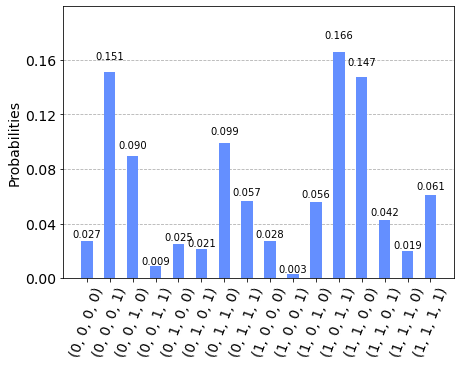

In [49]:
from qiskit.visualization import plot_histogram
circ2x2.measure_all()
handle = backend.process_circuit(circ2x2, n_shots =10000)
result_counts = backend.get_result(handle).get_counts()
plot_histogram(result_counts)

### IBMのクラウドシミュレータにジョブを実行

In [3]:
path = 'key/ibm-token'
f = open(path)
ibm_token = f.read()
f.close()
from pytket.extensions.qiskit.backends.config import set_ibmq_config
set_ibmq_config(ibmq_api_token=ibm_token)

In [ ]:
from pytket.extensions.qiskit import IBMQBackend, IBMQEmulatorBackend
backend = IBMQBackend("ibmq_qasm_simulator")
#circ2x0 = circ2x.copy()
#circ2c0 = backend.get_compiled_circuit(circ2x0,optimisation_level=0)
#print('Level 0')
#print('Circuit depth: ', circ2x0.depth())
#print('CX depth: ', circ2x0.depth_by_type(OpType.CX))
#render_circuit_jupyter(circ2x0)
circ2x1 = circ2x.copy()
circ2x1 = backend.get_compiled_circuit(circ2x1,optimisation_level=1)
print('Level 1')
print('Circuit depth: ', circ2x1.depth())
print('CX depth: ', circ2x1.depth_by_type(OpType.CX))
render_circuit_jupyter(circ2x1)
circ2x2 = circ2x.copy()
circ2x2 = backend.get_compiled_circuit(circ2x2,optimisation_level=2)
print('Level 2')
print('Circuit depth: ', circ2x2.depth())
print('CX depth: ', circ2x2.depth_by_type(OpType.CX))
render_circuit_jupyter(circ2x2)

NameError: name 'circ2x' is not defined

In [ ]:
circ2x2.measure_all()
handle = backend.process_circuit(circ2x2, n_shots =10000)
result_counts = backend.get_result(handle).get_counts()
plot_histogram(result_counts)

### IBMのクラウドシミュレータ（ibmq_lima）にジョブを実行
<img src="../fig/lima.png" width="250">


In [59]:
backend = IBMQEmulatorBackend("ibmq_lima")
#circ2x0 = circ2x.copy()
#circ2c0 = backend.get_compiled_circuit(circ2x0,optimisation_level=0)
#print('Level 0')
#print('Circuit depth: ', circ2x0.depth())
#print('CX depth: ', circ2x0.depth_by_type(OpType.CX))
#render_circuit_jupyter(circ2x0)
circ2x1 = circ2x.copy()
circ2x1 = backend.get_compiled_circuit(circ2x1,optimisation_level=1)
print('Level 1')
print('Circuit depth: ', circ2x1.depth())
print('CX depth: ', circ2x1.depth_by_type(OpType.CX))
render_circuit_jupyter(circ2x1)
circ2x2 = circ2x.copy()
circ2x2 = backend.get_compiled_circuit(circ2x2,optimisation_level=2)
print('Level 2')
print('Circuit depth: ', circ2x2.depth())
print('CX depth: ', circ2x2.depth_by_type(OpType.CX))
render_circuit_jupyter(circ2x2)

Level 1
Circuit depth:  337
CX depth:  142


Level 2
Circuit depth:  338
CX depth:  142


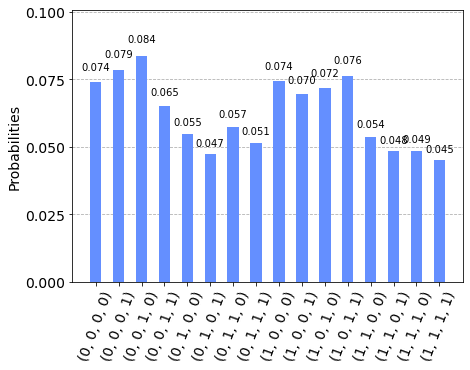

In [60]:
circ2x2.measure_all()
handle = backend.process_circuit(circ2x2, n_shots =10000)
result_counts = backend.get_result(handle).get_counts()
plot_histogram(result_counts)

### Braketのシミュレータにジョブを実行

In [61]:
from pytket.extensions.braket import BraketBackend
backend = BraketBackend(local = True)
#circ2x0 = circ2x.copy()
#circ2c0 = backend.get_compiled_circuit(circ2x0,optimisation_level=0)
#print('Level 0')
#print('Circuit depth: ', circ2x0.depth())
#print('CX depth: ', circ2x0.depth_by_type(OpType.CX))
#render_circuit_jupyter(circ2x0)
circ2x1 = circ2x.copy()
circ2x1 = backend.get_compiled_circuit(circ2x1,optimisation_level=1)
print('Level 1')
print('Circuit depth: ', circ2x1.depth())
print('CX depth: ', circ2x1.depth_by_type(OpType.CX))
render_circuit_jupyter(circ2x1)
circ2x2 = circ2x.copy()
circ2x2 = backend.get_compiled_circuit(circ2x2,optimisation_level=2)
print('Level 2')
print('Circuit depth: ', circ2x2.depth())
print('CX depth: ', circ2x2.depth_by_type(OpType.CX))
render_circuit_jupyter(circ2x2)

Level 1
Circuit depth:  201
CX depth:  66


Level 2
Circuit depth:  201
CX depth:  66


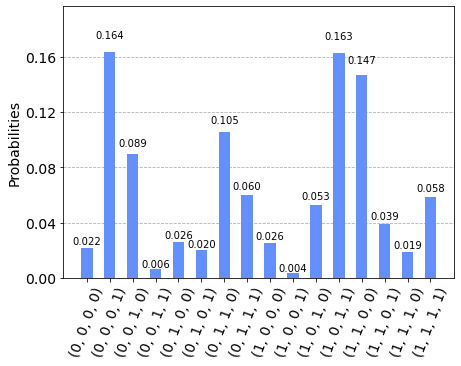

In [62]:
from qiskit.visualization import plot_histogram
circ2x2.measure_all()
handle = backend.process_circuit(circ2x2, n_shots =10000)
result_counts = backend.get_result(handle).get_counts()
plot_histogram(result_counts)

### Qulacsのシミュレータにジョブを実行

In [63]:
from pytket.extensions.qulacs import QulacsBackend
backend = QulacsBackend()
#circ2x0 = circ2x.copy()
#circ2c0 = backend.get_compiled_circuit(circ2x0,optimisation_level=0)
#print('Level 0')
#print('Circuit depth: ', circ2x0.depth())
#print('CX depth: ', circ2x0.depth_by_type(OpType.CX))
#render_circuit_jupyter(circ2x0)
#circ2x1 = circ2x.copy()
#circ2x1 = backend.get_compiled_circuit(circ2x1,optimisation_level=1)
print('Level 1')
print('Circuit depth: ', circ2x1.depth())
print('CX depth: ', circ2x1.depth_by_type(OpType.CX))
render_circuit_jupyter(circ2x1)
circ2x2 = circ2x.copy()
circ2x2 = backend.get_compiled_circuit(circ2x2,optimisation_level=2)
print('Level 2')
print('Circuit depth: ', circ2x2.depth())
print('CX depth: ', circ2x2.depth_by_type(OpType.CX))
render_circuit_jupyter(circ2x2)

Level 1
Circuit depth:  201
CX depth:  66


Level 2
Circuit depth:  201
CX depth:  66


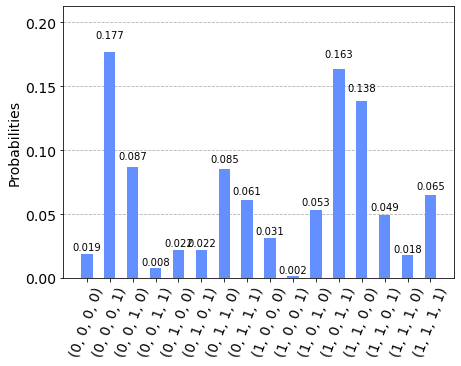

In [64]:
from qiskit.visualization import plot_histogram
circ2x2.measure_all()
handle = backend.process_circuit(circ2x2, n_shots =1000)
result_counts = backend.get_result(handle).get_counts()
plot_histogram(result_counts)

### 5-2. いくつかの量子回路の最適化関数や変換
a. `CliffordSimp`,

b. `RemoveRedundancies`, 

c. `CommuteThroughMultis`, 

e. `EulerAngleReduction`, 

d. `KAKDecomposition` (省略)

### a. `CliffordSimp`
2量子ビットゲートの数を減らすことができるクリフォードゲートの特定のシーケンスを探す。

In [84]:
# Circuit optimization by using compiler passes.
from pytket.passes import CliffordSimp
# A basic inefficient pattern can be reduced by 1 CX
simple = Circuit(2)
simple.CX(0, 1).S(1).CX(1, 0)
render_circuit_jupyter(simple)

CliffordSimp().apply(simple)
render_circuit_jupyter(simple)

In [7]:
from pytket import Circuit, OpType
from pytket.passes import CliffordSimp

# The same pattern, up to commutation and local Clifford algebra
circ = Circuit(3)
circ.Rz(0.2, 0)
circ.Rx(0.35, 1)
circ.V(0).H(1).CX(0, 1).CX(1, 2).Rz(-0.6, 2).CX(1, 2).CX(0, 1).Vdg(0).H(1)
circ.H(1).H(2).CX(0, 1).CX(1, 2).Rz(0.8, 2).CX(1, 2).CX(0, 1).H(1).H(2)
circ.Rx(0.1, 1)
print('Circuit depth: ', circ.depth())
print('CX depth: ', circ.depth_by_type(OpType.CX))
render_circuit_jupyter(circ)
CliffordSimp().apply(circ)
print('Circuit depth: ', circ.depth())
print('CX depth: ', circ.depth_by_type(OpType.CX))
render_circuit_jupyter(circ)

Circuit depth:  16
CX depth:  8


Circuit depth:  12
CX depth:  7


### b. `RemoveRedundancies`
ゼロパラメータの回転ゲート、ゲートと逆のペア、同じ基底で隣接する回転ゲートなどを削減します。

In [8]:
from pytket.passes import RemoveRedundancies
circ = Circuit(3, 3)
circ.Rx(0.92, 0).CX(1, 2).Rx(-0.18, 0)  # Adjacent Rx gates can be merged
circ.CZ(0, 1).Ry(0.11, 2).CZ(0, 1)      # CZ is self-inverse
circ.add_gate(OpType.XXPhase, 0.6, [0, 1])
circ.add_gate(OpType.YYPhase, 0, [0, 1])    # 0-angle rotation does nothing
circ.add_gate(OpType.ZZPhase, -0.84, [0, 1])
circ.Rx(0.03, 0).Rz(-0.9, 1).measure_all()  # Effect of Rz is eliminated by measurement
print('Circuit depth: ', circ.depth())
print('CX depth: ', circ.depth_by_type(OpType.CX))
render_circuit_jupyter(circ)

RemoveRedundancies().apply(circ)
print('Circuit depth: ', circ.depth())
print('CX depth: ', circ.depth_by_type(OpType.CX))
render_circuit_jupyter(circ)


Circuit depth:  9
CX depth:  1


Circuit depth:  5
CX depth:  1


### c. `CommuteThroughMultis`
"1量子ビットゲートと可換な"2量子ビットゲートが先に作用している場合、これらを交換する。

In [76]:
from pytket.passes import CommuteThroughMultis
circD = Circuit(3)
circD.CX(0,2).X(2)
render_circuit_jupyter(circD)
CommuteThroughMultis().apply(circD)
render_circuit_jupyter(circD)

### d. `EulerAngleReduction`
`EulerAngleReduction`では、ユニタリ行列のオイラー角分解を与える。

In [10]:
from pytket.circuit import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
from pytket.passes import EulerAngleReduction, auto_rebase_pass
rebase = auto_rebase_pass({OpType.CZ, OpType.Rx, OpType.Rz})
circE = Circuit(1)
circE.H(0).T(0)
render_circuit_jupyter(circE)
rebase.apply(circE)
render_circuit_jupyter(circE)
EulerAngleReduction(OpType.Rx, OpType.Rz).apply(circE)
render_circuit_jupyter(circE)
EulerAngleReduction(OpType.Rz, OpType.Rx).apply(circE)
render_circuit_jupyter(circE)

In [13]:
from pytket.circuit import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
from pytket.passes import EulerAngleReduction, auto_rebase_pass
rebase = auto_rebase_pass({OpType.CZ, OpType.Rx, OpType.Ry})
circE = Circuit(1)
circE.H(0).T(0)
render_circuit_jupyter(circE)
rebase.apply(circE)
render_circuit_jupyter(circE)
#EulerAngleReduction(OpType.Rx, OpType.Ry).apply(circE)
#render_circuit_jupyter(circE)
EulerAngleReduction(OpType.Ry, OpType.Rx).apply(circE)
render_circuit_jupyter(circE)

### 5-3. 量子回路の最適化のカスタマイズ: 
- `SequencePass`

tketにはそのほかにも多くの量子回路最適化を用意している。
これらを最適化のパスに組み込みたい場合や自分で実装した最適化関数をパスに組み込みたい場合には`SequencePass`を利用すれば、カスタマイズが可能である。

In [14]:
from pytket import Circuit, OpType
from pytket.passes import auto_rebase_pass, EulerAngleReduction, SequencePass
rebase = auto_rebase_pass({OpType.CZ, OpType.Rz, OpType.Rx})
circ = Circuit(3)
circ.CX(0, 1).Rx(0.3, 1).CX(2, 1).Rz(0.8, 1)
render_circuit_jupyter(circ)

circ1 = circ.copy()
rebase.apply(circ1)
EulerAngleReduction(OpType.Rz, OpType.Rx).apply(circ1)
render_circuit_jupyter(circ1)

circ2 = circ.copy()
comp = SequencePass([rebase, EulerAngleReduction(OpType.Rz, OpType.Rx)])
comp.apply(circ2)
render_circuit_jupyter(circ2)

参考
- pytket.passes https://cqcl.github.io/tket/pytket/api/passes.html

弊社Quantinuumのご紹介
- ウェブサイト（ 英語 ）： https://www.quantinuum.com/
- 各種技術詳細（ 英語 ）： https://www.quantinuum.com/products
- プレスリリース（ 日本語 ）： https://japan.zdnet.com/company/30001168/release/　
- Twitter（ 日本語 ）： https://twitter.com/quantinuum_jp
- 日本チーム主催の勉強会（ 日本語 ）： https://cambridgequantum.connpass.com/
- 採用情報（ 英語 ）：https://www.quantinuum.com/careers

Cambridge Quantumのご紹介
- ウェブサイト（ 英語 ）： https://cambridgequantum.com/
- 学術論文（ 英語 ）： https://cambridgequantum.com/our-publications/　